### Langevin vs Annealed Langevin sur une GMM 2D (score exact)
L'objectif est d'illustrer les limites d’un Langevin **single-scale** sur une distribution multi-modale.

Puis de montrer comment l’**Annealed Langevin Dynamics (ALD)** (scores conditionnés au bruit p-sigma) améliore le mixing.

Ici on a accès au **score exact** via autograd, donc on isole vraiment l’effet du sampler.

In [1]:
import torch
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np
import math

torch.set_default_dtype(torch.float32)
device = torch.device("cpu")
print("Device:", device)

def t(x):
    return torch.as_tensor(x, dtype=torch.get_default_dtype(), device=device)

Device: cpu


## GMM "difficile"
Difficile parce que :
- **multi-modale** avec des modes bien séparés (vallées de faible densité donc difficile à traverser),
- **déséquilibrée** (un gros mode dominant + plusieurs petits modes rares),
- en pratique, un Langevin single-scale initialisé loin des modes **collapse vite** sur un mode proche et récupère mal les proportions globales.


In [2]:
means_list = [
    [-15,  0.0],
    [ 10.0,  0.0],
    [  0.0, 15.0],
    [  0, -6.0],
    [  0,  0],
    [  8.0,  8.0],
    [  8.0, -8.0],
]
mean = torch.stack([t(m) for m in means_list], dim=0)  # (K,2)
K = mean.size(0)

cov_list = [
    2.4 *torch.eye(2, device=device),
    0.4 * torch.eye(2, device=device),
    0.7 * torch.eye(2, device=device),
    0.7 *torch.eye(2, device=device),
    3.0 * torch.eye(2, device=device),
    0.05 * torch.eye(2, device=device),
    0.05 * torch.eye(2, device=device),
]
cov = torch.stack(cov_list, dim=0)  # (K,2,2)

weights_list = [0.02, 0.16, 0.12, 0.11, 0.45, 0.02, 0.12]
w = t(weights_list)
w = w / w.sum()

weights = dist.Categorical(w)
gaussians = dist.MultivariateNormal(mean, cov)
target_dist = dist.MixtureSameFamily(weights, gaussians)

print("K =", K)
print("Weights:", w.detach().cpu().numpy())

K = 7
Weights: [0.02 0.16 0.12 0.11 0.45 0.02 0.12]


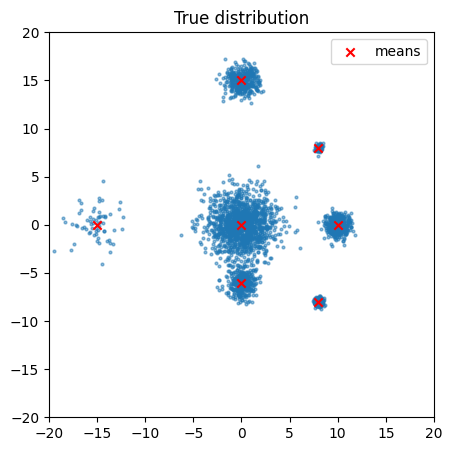

In [3]:
X_true = target_dist.sample((3000,)).cpu()

plt.figure(figsize=(5, 5))

plt.scatter(X_true[:, 0],X_true[:, 1],s=4, alpha=0.5)
plt.scatter(mean[:, 0].cpu(), mean[:, 1].cpu(), c="red", marker="x", label="means")
plt.title("True distribution")
plt.xlim(-20, 20); plt.ylim(-20, 20)
plt.gca().set_aspect("equal")
plt.legend()
plt.show()

## 2) Score exact (autograd) + familles bruitées \(p_\sigma\)

In [4]:
def score(distrib, x):
    x = x.clone().detach().requires_grad_(True)
    lp = distrib.log_prob(x)
    (s,) = torch.autograd.grad(lp.sum(), x)
    return s

true_clean_score = lambda x: score(target_dist, x)

def construct_GMM_noised_distribution(sigmas, loc, cov, weights):
    d = loc.size(-1)
    out = []
    for sigma in sigmas:
        g = dist.MultivariateNormal(loc, cov + torch.eye(d, device=device) * sigma**2)
        out.append(dist.MixtureSameFamily(weights, g))
    return out

SIGMA_MIN = 0.1
SIGMA_MAX = 20.0
N_SIGMAS  = 10

sigmas = torch.logspace(
    torch.log10(t(SIGMA_MIN)),
    torch.log10(t(SIGMA_MAX)),
    N_SIGMAS,
    device=device
).flip(0)

true_noised_dist = construct_GMM_noised_distribution(sigmas, mean, cov, weights)
true_noised_scores = [lambda x, d=d: score(d, x) for d in true_noised_dist]

print("Sigmas:", sigmas.detach().cpu().numpy())

Sigmas: [20.000002   11.100946    6.1615505   3.419952    1.898235    1.0536104
  0.58480364  0.32459366  0.18016483  0.1       ]


### Calibration SNR : estimation de $\mathbb{E}\,\|\nabla_x \log p\|^2$

On estime par Monte Carlo la quantité $\mathbb{E}_{X\sim p}\big[\|\nabla_x \log p(X)\|^2\big]$ (et pareil pour chaque $p_\sigma$).  
Ça sert uniquement à **caler l’échelle des pas** dans Langevin quand on utilise une règle de type SNR : le step $\tau$ dépend de $\|\text{score}\|$, donc on a besoin d’un ordre de grandeur “typique”.

Remarque : ici on le pré-calcule “offline” pour être stable et reproductible, mais on pourrait aussi **estimer $\|\text{score}\|$ en ligne** pendant le sampling (par batch), et adapter $tau$ dynamiquement.


In [5]:
def estimate_score_norm_true(distrib, score_fn, n_samples=30000):
    x = distrib.sample((n_samples,)).to(device)
    s = score_fn(x)
    return (s**2).sum(dim=1).mean().item()

norm_clean_true = estimate_score_norm_true(target_dist, true_clean_score, n_samples=30000)
print("E[||score_clean||^2] ≈", norm_clean_true)

norms_true_sigmas = []
for i in range(len(sigmas)):
    norms_true_sigmas.append(
        estimate_score_norm_true(true_noised_dist[i], true_noised_scores[i], n_samples=30000)
    )
norms_true_sigmas = np.array(norms_true_sigmas, dtype=np.float64)
print("E[||score_σ||^2] par σ:", norms_true_sigmas)

E[||score_clean||^2] ≈ 7.233089447021484
E[||score_σ||^2] par σ: [4.60221153e-03 1.28798373e-02 3.09502427e-02 8.27933252e-02
 3.00146788e-01 8.66482079e-01 1.84229326e+00 3.30808377e+00
 4.99922085e+00 6.32580805e+00]


## Utils : assignation + histogrammes de proportions

In [6]:
def assign_clusters(x, means):
    dist2 = ((x.unsqueeze(1) - means.unsqueeze(0))**2).sum(dim=-1)  # (N,K)
    return dist2.argmin(dim=1)

def plot_cluster_hist_multi(samples_list, means, true_weights, labels, title=""):
    assert len(samples_list) == len(labels)

    means_cpu = means.detach().cpu()
    true_w = true_weights.detach().cpu().numpy()
    K = means_cpu.size(0)

    idx = np.arange(K)
    n_models = len(samples_list)
    width = 0.8 / (n_models + 1)

    plt.figure(figsize=(8, 4))
    plt.bar(idx - 0.5 * width * (n_models), true_w, width, label="poids théoriques")

    for i, (samples, lab) in enumerate(zip(samples_list, labels)):
        samples_cpu = samples.detach().cpu()
        clusters = assign_clusters(samples_cpu, means_cpu)
        counts = torch.bincount(clusters, minlength=K).float()
        emp = (counts / counts.sum()).numpy()

        offset = (i + 1) * width
        plt.bar(idx - 0.5 * width * (n_models) + offset, emp, width, label=lab)

    plt.xticks(idx, [f"k={i}" for i in range(K)])
    plt.ylim(0, 0.6)
    plt.ylabel("proportion")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

## 5) Samplers : Langevin single-scale et ALD multi-scale
- les fonctins ont l'air compliqué mais c'est juste parce que on veut save des trajectoire, les algorithme de langevin et ALD sont très straight forward sinon


In [7]:
def langevin_true(
    score_fn,
    prior_dist,
    SNR,
    norm_score_true,
    n_steps,
    n_chain,
    plot_evolution=False,
    n_panels=12,
    means=None,
    xlim=(-20, 20),
    ylim=(-20, 20),
    figsize=None,
    figpath=None,
):
    D = 2
    # Calibration SNR (single-scale) :
    # on choisit un pas tau ~ SNR / E||score||^2 pour avoir une update "du bon ordre de grandeur"
    # (ici norm_score_true ≈ E||∇ log p||^2 sous la target).
    tau = 2 * D * SNR / norm_score_true
    noise_std = math.sqrt(2 * tau)  # discretisation Langevin: sqrt(2 tau) * z
    print(f"[Langevin] tau={tau:.3e}, noise_std={noise_std:.3e}")

    # Init des chaînes depuis un prior (typiquement hors-manifold / hors modes pour illustrer les limites)
    X = prior_dist.sample((n_chain,)).to(device)

    if not plot_evolution:
        for _ in range(n_steps):
            # Un pas de Langevin:
            # X <- X + tau * score(X) + sqrt(2 tau) * N(0,I)
            # -> local: ça grimpe le log-density mais ça traverse mal les vallées entre modes.
            X = X + tau * score_fn(X) + noise_std * torch.randn_like(X)
        return X

    # evolution: snapshots à itérations fixes
    if figsize is None:
        figsize = (3 * n_panels, 3)

    snapshot_iters = np.linspace(0, n_steps, n_panels, dtype=int)
    snapshot_set = set(snapshot_iters.tolist())

    snapshots = []
    iters_recorded = []

    for k in range(n_steps + 1):
        if k in snapshot_set:
            snapshots.append(X.detach().cpu())
            iters_recorded.append(k)

        if k == n_steps:
            break

        # update langevin
        X = X + tau * score_fn(X) + noise_std * torch.randn_like(X)

    fig, axes = plt.subplots(1, len(snapshots), figsize=figsize)
    if len(snapshots) == 1:
        axes = [axes]

    means_cpu = means.detach().cpu() if means is not None else None
    for ax, X_snap in zip(axes, snapshots):
        Xn = X_snap.numpy()
        ax.scatter(Xn[:, 0], Xn[:, 1], s=2, alpha=0.5)
        if means_cpu is not None:
            ax.scatter(means_cpu[:, 0], means_cpu[:, 1], c="red", marker="x", s=40)
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    if figpath is not None:
        plt.savefig(figpath, dpi=200, bbox_inches="tight")
    plt.show()

    return X


def ald_true(
    prior,
    true_noisy_scores,
    sigmas,
    SNR,
    norms_true_sigmas,
    T_per_level,
    n_chain,
    plot_evolution=False,
    means=None,
    xlim=(-20, 20),
    ylim=(-20, 20),
    figsize=None,
    figpath=None,
):
    D = 2
    # Init depuis un prior potentiellement très large (ex: uniforme): au début on veut surtout mixer.
    X = prior.sample((n_chain,)).to(device)

    snapshots = []
    if plot_evolution:
        snapshots.append(X.detach().cpu())  # init

    for i in range(len(sigmas)):
        # Multi-scale: à grand sigma, les modes se "lissent" et les chaînes peuvent bouger entre régions.
        # Le pas est calibré niveau par niveau via E||score_sigma||^2.
        tau_i = 2 * D * SNR / norms_true_sigmas[i]
        noise_std_i = math.sqrt(2 * tau_i)
        print(f"[ALD] i={i}, σ={float(sigmas[i]):.3g}, tau={tau_i:.3e}, noise_std={noise_std_i:.3e}")

        for _ in range(T_per_level):
            # Un pas de Langevin sur p_sigma:
            # X = X + tau_i * score_sigma(X) + sqrt(2 tau_i) * z
            # puis on descend sigma -> sharpening progressif.
            X = X + tau_i * true_noisy_scores[i](X) + noise_std_i * torch.randn_like(X)

        if plot_evolution:
            snapshots.append(X.detach().cpu())  # fin de niveau

    if not plot_evolution:
        return X

    # plot évolution (init + fin de chaque niveau)
    n_panels = len(snapshots)
    if figsize is None:
        figsize = (2.0 * n_panels, 2.0)

    fig, axes = plt.subplots(1, n_panels, figsize=figsize)
    if n_panels == 1:
        axes = [axes]

    means_cpu = means.detach().cpu() if means is not None else None
    for ax, X_snap in zip(axes, snapshots):
        Xn = X_snap.numpy()
        ax.scatter(Xn[:, 0], Xn[:, 1], s=2, alpha=0.5)
        if means_cpu is not None:
            ax.scatter(means_cpu[:, 0], means_cpu[:, 1], c="red", marker="x", s=25)
        ax.set_xlim(*xlim); ax.set_ylim(*ylim)
        ax.set_aspect("equal")
        ax.set_xticks([]); ax.set_yticks([])

    plt.tight_layout()
    if figpath is not None:
        plt.savefig(figpath, dpi=200, bbox_inches="tight")
    plt.show()

    return X


## Priors + hyperparams 

In [8]:
SNR = 0.1

# prior gauss
prior_mean = t([0.0, 0.0])
prior_cov  = 10.0 * torch.eye(2, device=device)
prior_gauss = dist.MultivariateNormal(prior_mean, prior_cov)

# prior uniform 
LOW  = torch.tensor([-20.0, -20.0], device=device)
HIGH = torch.tensor([ 20.0,  20.0], device=device)
prior_uniform = dist.Uniform(low=LOW, high=HIGH)

N_CHAIN = 2000
ALD_T_PER_LEVEL = 30 # nombre de step par niveau de bruit
L_simple_steps = ALD_T_PER_LEVEL*len(sigmas)

##  Comparaison : LD vs ALD + proportions avec prior gaussien

[Langevin] tau=5.530e-02, noise_std=3.326e-01
[ALD] i=0, σ=20, tau=8.691e+01, noise_std=1.318e+01
[ALD] i=1, σ=11.1, tau=3.106e+01, noise_std=7.881e+00
[ALD] i=2, σ=6.16, tau=1.292e+01, noise_std=5.084e+00
[ALD] i=3, σ=3.42, tau=4.831e+00, noise_std=3.108e+00
[ALD] i=4, σ=1.9, tau=1.333e+00, noise_std=1.633e+00
[ALD] i=5, σ=1.05, tau=4.616e-01, noise_std=9.609e-01
[ALD] i=6, σ=0.585, tau=2.171e-01, noise_std=6.590e-01
[ALD] i=7, σ=0.325, tau=1.209e-01, noise_std=4.918e-01
[ALD] i=8, σ=0.18, tau=8.001e-02, noise_std=4.000e-01
[ALD] i=9, σ=0.1, tau=6.323e-02, noise_std=3.556e-01


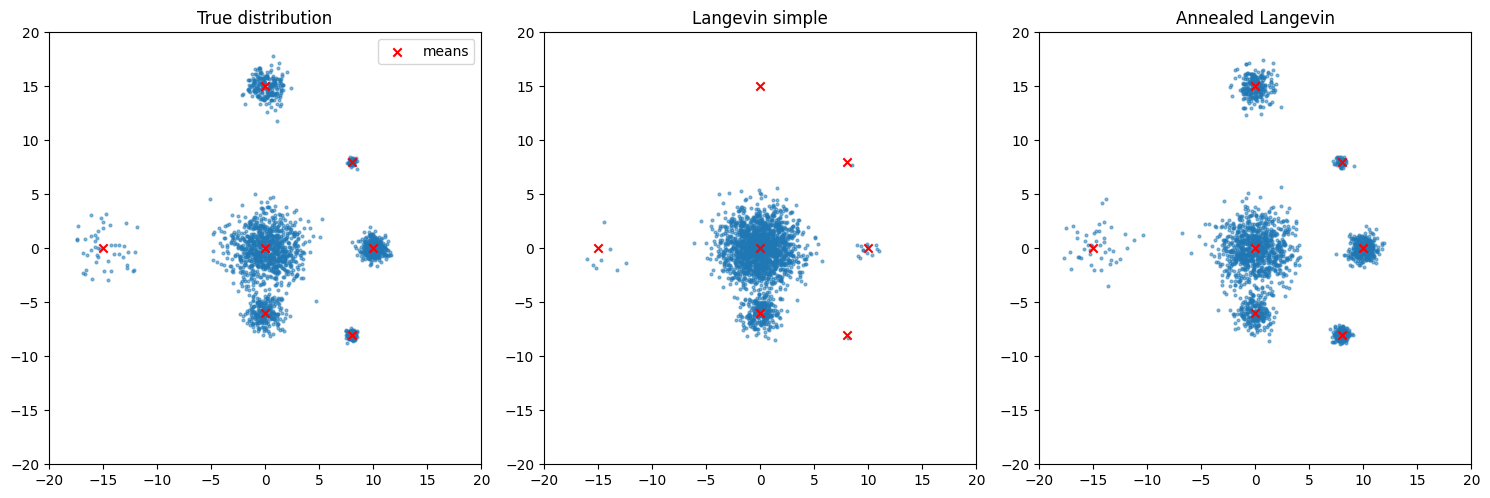

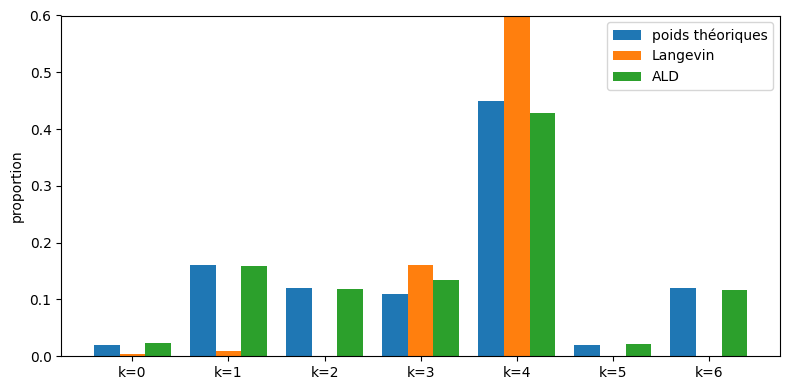

In [9]:
X_langevin = langevin_true(
    score_fn=true_clean_score,
    prior_dist=prior_gauss,
    SNR=SNR,
    norm_score_true=norm_clean_true,
    n_steps=L_simple_steps,
    n_chain=N_CHAIN,
    plot_evolution=False,
).detach().cpu()

X_ald = ald_true(
    prior=prior_gauss,
    true_noisy_scores=true_noised_scores,
    sigmas=sigmas,
    SNR=SNR,
    norms_true_sigmas=norms_true_sigmas,
    T_per_level=ALD_T_PER_LEVEL,
    n_chain=N_CHAIN,
    plot_evolution=False,
).detach().cpu()

X_true = target_dist.sample((N_CHAIN,)).cpu()

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.scatter(X_true[:, 0], X_true[:, 1], s=4, alpha=0.5)
plt.scatter(mean[:, 0].cpu(), mean[:, 1].cpu(), c="red", marker="x", label="means")
plt.title("True distribution")
plt.xlim(-20, 20); plt.ylim(-20, 20)
plt.gca().set_aspect("equal")
plt.legend()

plt.subplot(1, 3, 2)
plt.scatter(X_langevin[:, 0], X_langevin[:, 1], s=4, alpha=0.5)
plt.scatter(mean[:, 0].cpu(), mean[:, 1].cpu(), c="red", marker="x")
plt.title("Langevin simple")
plt.xlim(-20, 20); plt.ylim(-20, 20)
plt.gca().set_aspect("equal")

plt.subplot(1, 3, 3)
plt.scatter(X_ald[:, 0], X_ald[:, 1], s=4, alpha=0.5)
plt.scatter(mean[:, 0].cpu(), mean[:, 1].cpu(), c="red", marker="x")
plt.title("Annealed Langevin")
plt.xlim(-20, 20); plt.ylim(-20, 20)
plt.gca().set_aspect("equal")

plt.tight_layout()
plt.show()

plot_cluster_hist_multi(
    samples_list=[X_langevin, X_ald],
    means=mean,
    true_weights=w,
    labels=["Langevin", "ALD"],
    title="",
)

## Évolution des particules (prior uniforme)

[Langevin] tau=5.530e-02, noise_std=3.326e-01


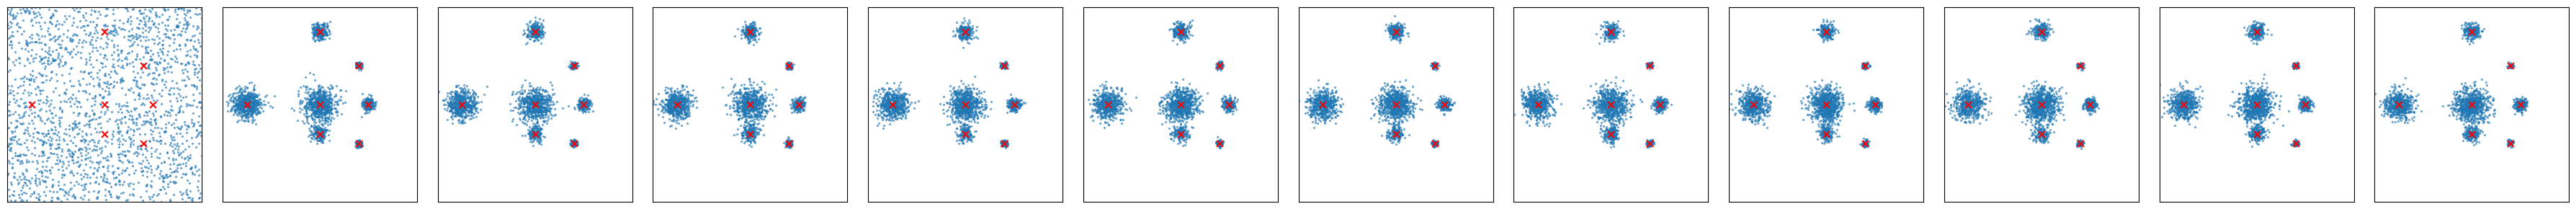

In [10]:
_ = langevin_true(
    score_fn=true_clean_score,
    prior_dist=prior_uniform,
    SNR=SNR,
    norm_score_true=norm_clean_true,
    n_steps=L_simple_steps * 100,   
    n_chain=N_CHAIN,
    plot_evolution=True,
    n_panels=12,
    means=mean,
    xlim=(-20, 20),
    ylim=(-20, 20),
)

### Commentaires (LD, prior uniforme)
- Les particules vont très vite vers un **mode proche** (attraction locale du score), puis y restent : la dynamique traverse mal les vallées de faible densité entre modes.
- On observe donc un **collapse** et une mauvaise exploration globale : certains modes deviennent sur-représentés.
- Par exemple, le mode le plus à gauche récupère **beaucoup plus** de particules que il ne faudrait car il est isolée.


[ALD] i=0, σ=20, tau=8.691e+01, noise_std=1.318e+01
[ALD] i=1, σ=11.1, tau=3.106e+01, noise_std=7.881e+00
[ALD] i=2, σ=6.16, tau=1.292e+01, noise_std=5.084e+00
[ALD] i=3, σ=3.42, tau=4.831e+00, noise_std=3.108e+00
[ALD] i=4, σ=1.9, tau=1.333e+00, noise_std=1.633e+00
[ALD] i=5, σ=1.05, tau=4.616e-01, noise_std=9.609e-01
[ALD] i=6, σ=0.585, tau=2.171e-01, noise_std=6.590e-01
[ALD] i=7, σ=0.325, tau=1.209e-01, noise_std=4.918e-01
[ALD] i=8, σ=0.18, tau=8.001e-02, noise_std=4.000e-01
[ALD] i=9, σ=0.1, tau=6.323e-02, noise_std=3.556e-01


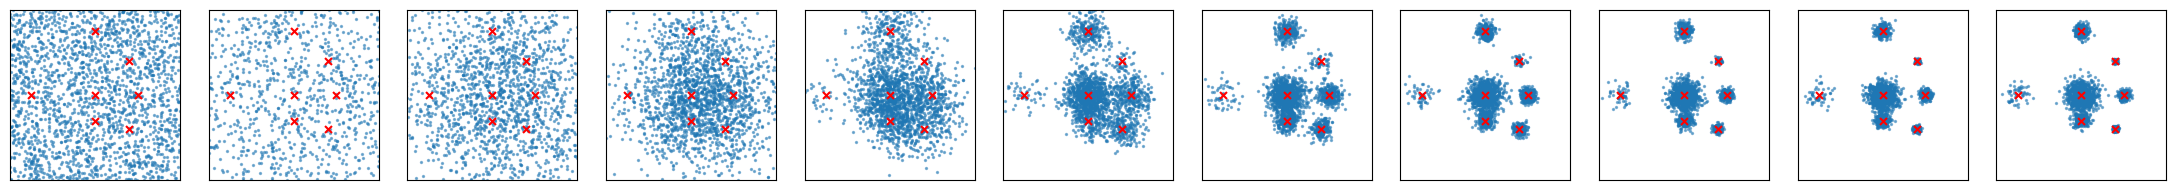

In [11]:
_ = ald_true(
    prior=prior_uniform,
    true_noisy_scores=true_noised_scores,
    sigmas=sigmas,
    SNR=SNR,
    norms_true_sigmas=norms_true_sigmas,
    T_per_level=ALD_T_PER_LEVEL,
    n_chain=N_CHAIN,
    plot_evolution=True,
    means=mean,
    xlim=(-20, 20),
    ylim=(-20, 20),
)

### Commentaires (ALD, prior uniforme)
- À grand $\sigma$, les modes se lissent et les particules **mélangent mieux** (elles peuvent changer de bassin).
- En descendant $\sigma$, la distribution se **re-sharpen** et les particules se répartissent plus correctement entre les modes.
